In [14]:
def remove_newlines(serie):
    serie = serie.str.replace('\n', ' ')
    serie = serie.str.replace('\\n', ' ')
    serie = serie.str.replace('  ', ' ')
    serie = serie.str.replace('  ', ' ')
    return serie

In [15]:
import os
import pandas as pd

domain = "docs.youdianzhishi.com"
full_url = "https://docs.youdianzhishi.com/"

# Create a list to store the text files
texts=[]

# Get all the text files in the text directory
for file in os.listdir("text/" + domain + "/"):

    # Open the file and read the text
    with open("text/" + domain + "/" + file, "r", encoding="UTF-8") as f:
        text = f.read()

        # Omit the first 11 lines and the last 4 lines, then replace -, _, and #update with spaces.
        texts.append((file[11:-4].replace('-',' ').replace('_', ' ').replace('#update',''), text))

# Create a dataframe from the list of texts
df = pd.DataFrame(texts, columns = ['fname', 'text'])

# Set the text column to be the raw text with the newlines removed
df['text'] = df.fname + ". " + remove_newlines(df.text)
df.to_csv('processed/scraped.csv')
df.head()

<ipython-input-14-429202555403>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  serie = serie.str.replace('\\n', ' ')


,fname,text
0,nzhishi.com k8s monitor operator install,nzhishi.com k8s monitor operator install. 安装...
1,nzhishi.com k8s devops harbor,nzhishi.com k8s devops harbor. Harbor | 优点知识...
2,nzhishi.com prometheus basic architecture,nzhishi.com prometheus basic architecture. 系...
3,nzhishi.com k8s config configmap,nzhishi.com k8s config configmap. ConfigMap ...
4,nzhishi.com prometheus k8s pushgateway,nzhishi.com prometheus k8s pushgateway. Push...


In [5]:
%pip install tiktoken matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 50.1 kB/s eta 0:00:00m eta 0:00:010:00:04
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.6/229.6 kB 40.8 kB/s eta 0:00:0031m39.0 kB/s eta 0:00:01
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 65.8 kB/s eta 0:00:000:00:01m eta 0:00:01
  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.2/63.2 kB 68.9 kB/s eta 0:00:00 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


<Axes: >

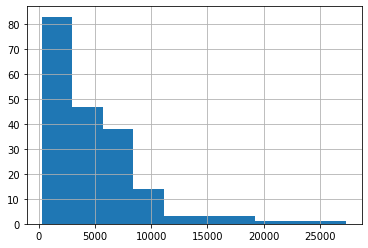

In [16]:
import tiktoken
import pandas as pd

# Load the cl100k_base tokenizer which is designed to work with the ada-002 model
tokenizer = tiktoken.get_encoding("cl100k_base")

df = pd.read_csv('processed/scraped.csv', index_col=0)
df.columns = ['title', 'text']

# Tokenize the text and save the number of tokens to a new column
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))

# Visualize the distribution of the number of tokens per row using a histogram
df.n_tokens.hist()

In [17]:
max_tokens = 500

# Function to split the text into chunks of a maximum number of tokens
def split_into_many(text, max_tokens = max_tokens):

    # Split the text into sentences
    sentences = text.split('. ')

    # Get the number of tokens for each sentence
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]
    
    chunks = []
    tokens_so_far = 0
    chunk = []

    # Loop through the sentences and tokens joined together in a tuple
    for sentence, token in zip(sentences, n_tokens):

        # If the number of tokens so far plus the number of tokens in the current sentence is greater 
        # than the max number of tokens, then add the chunk to the list of chunks and reset
        # the chunk and tokens so far
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0

        # If the number of tokens in the current sentence is greater than the max number of 
        # tokens, go to the next sentence
        if token > max_tokens:
            continue

        # Otherwise, add the sentence to the chunk and add the number of tokens to the total
        chunk.append(sentence)
        tokens_so_far += token + 1

    return chunks
    

shortened = []

# Loop through the dataframe
for row in df.iterrows():

    # If the text is None, go to the next row
    if row[1]['text'] is None:
        continue

    # If the number of tokens is greater than the max number of tokens, split the text into chunks
    if row[1]['n_tokens'] > max_tokens:
        shortened += split_into_many(row[1]['text'])
    
    # Otherwise, add the text to the list of shortened texts
    else:
        shortened.append( row[1]['text'] )

<Axes: >

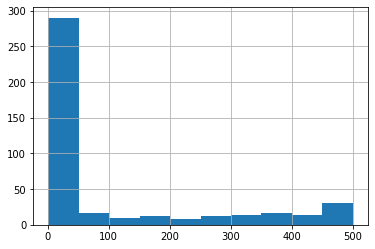

In [18]:
df = pd.DataFrame(shortened, columns = ['text'])
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

In [19]:
import openai

df['embeddings'] = df.text.apply(lambda x: openai.Embedding.create(input=x, engine='text-embedding-ada-002')['data'][0]['embedding'])

df.to_csv('processed/embeddings.csv')
df.head()

,text,n_tokens,embeddings
0,nzhishi.com k8s monitor operator install.,11,"[-0.0006176101160235703, -0.013915419578552246..."
1,nzhishi.com k8s devops harbor.,11,"[0.011758721433579922, -0.02716861665248871, 0..."
2,.,1,"[-0.00875202938914299, -0.016862068325281143, ..."
3,"-f values-prod.yaml -n kube-opsRelease ""harbor...",19,"[0.004934624768793583, -0.04268467798829079, 0..."
4,.,1,"[-0.008761508390307426, -0.016880812123417854,..."


In [1]:
%pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd

df=pd.read_csv('processed/embeddings.csv', index_col=0)
df['embeddings'] = df['embeddings'].apply(eval).apply(np.array)

df.head()

,text,n_tokens,embeddings
0,nzhishi.com k8s monitor operator install.,11,"[-0.0006176101160235703, -0.013915419578552246..."
1,nzhishi.com k8s devops harbor.,11,"[0.011758721433579922, -0.02716861665248871, 0..."
2,.,1,"[-0.00875202938914299, -0.016862068325281143, ..."
3,"-f values-prod.yaml -n kube-opsRelease ""harbor...",19,"[0.004934624768793583, -0.04268467798829079, 0..."
4,.,1,"[-0.008761508390307426, -0.016880812123417854,..."


In [2]:
%pip install plotly scipy scikit-learn -i http://mirrors.aliyun.com/pypi/simple/ --trusted-host mirrors.aliyun.com

Looking in indexes: http://mirrors.aliyun.com/pypi/simple/
Note: you may need to restart the kernel to use updated packages.


In [8]:
from openai.embeddings_utils import distances_from_embeddings

def create_context(question, df, max_len=1800):
    """
    Create a context for a question by finding the most similar context from the dataframe
    """

    # Get the embeddings for the question
    q_embeddings = openai.Embedding.create(input=question, engine='text-embedding-ada-002')['data'][0]['embedding']

    # Get the distances from the embeddings
    df['distances'] = distances_from_embeddings(q_embeddings, df['embeddings'].values, distance_metric='cosine')


    returns = []
    cur_len = 0

    # Sort by distance and add the text to the context until the context is too long
    for i, row in df.sort_values('distances', ascending=True).iterrows():
        
        # Add the length of the text to the current length
        cur_len += row['n_tokens'] + 4
        
        # If the context is too long, break
        if cur_len > max_len:
            break
        
        # Else add it to the text that is being returned
        returns.append(row["text"])

    # Return the context
    return "\n\n###\n\n".join(returns)

In [9]:
import pandas as pd
import numpy as np

df = pd.read_csv('processed/embeddings.csv', index_col=0)
df['embeddings'] = df['embeddings'].apply(eval).apply(np.array)
df.head()

,text,n_tokens,embeddings
0,nzhishi.com k8s monitor operator install.,11,"[-0.0006176101160235703, -0.013915419578552246..."
1,nzhishi.com k8s devops harbor.,11,"[0.011758721433579922, -0.02716861665248871, 0..."
2,.,1,"[-0.00875202938914299, -0.016862068325281143, ..."
3,"-f values-prod.yaml -n kube-opsRelease ""harbor...",19,"[0.004934624768793583, -0.04268467798829079, 0..."
4,.,1,"[-0.008761508390307426, -0.016880812123417854,..."


In [11]:
import openai

def answer_question(
    df,
    question="Kubernetes是什么？",
    max_len=1800,
    debug=False,
    max_tokens=150,
    stop_sequence=None
):
    """
    根据 dataframe texts 中最相似的上下文回答问题
    """
    context = create_context(
        question,
        df,
        max_len=max_len,
    )
    if debug:
        print("Context:\n" + context)
        print("\n\n")

    try:
        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",
            temperature=0,
            max_tokens=max_tokens,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=stop_sequence,
            messages=[
                {"role": "system", "content": "You are youdianzhishi's official knowledge base AI robot assistant"},
                {"role": "user", "content": f"Answer the question based on the context below with Chinese, and if the question can't be answered based on the context, say \"I don't know\"\n\nContext: {context}\n\n---\n\nQuestion: {question}\nAnswer:"},
            ]
        )
        result = ''
        for choice in response.choices:
            result += choice.message.content
        return result
    except Exception as e:
        print(e)
        return ""

answer_question(df, question="如何使用Prometheus Operator?", debug=True)


Context:
volumes: - name: prometheus-k8s-db persistentVolumeClaim:  claimName: prometheus-k8s-db-prometheus-k8s-0......现在即使我们的 Pod 挂掉了，数据也不会丢失了。到这里 Prometheus Operator 的一些基本配置就算完成了，对于大型的监控集群还需要做一些其他配置，比如前面我们学习的使用 Thanos 和 VictorialMetrics 来做 Prometheus 集群的高可用以及数据远程存储，对于 Prometheus Operator 来说，要配置 Thanos 也比较简单，因为 prometheus 这个 CRD 对象本身也支持的。关于 prometheus operator 中如何配置 thanos，可以查看官方文档的介绍：https://github.com/coreos/prometheus-operator/blob/master/Documentation/thanos.md。但是 Prometheus Operator 没有提供对 VictorialMetrics 的支持，不过 VM Operator 可以识别 Prometheus Operator 的 ServiceMonitor、PodMonitor、PrometheusRule 和 Probe 对象，如果我们使用的是 Prometheus Operator，然后想使用 VM 来做监控数据的远程存储的话，那我们只有通过去配置 Prometheus 的 remote-write 了，同样 prometheus 这个 crd 对象中也支持配置远程存储。$ kubectl explain prometheus.spec.remoteWriteKIND:  PrometheusVERSION: monitoring.coreos.com/v1RESOURCE: remoteWrite <[]Object>DESCRIPTION:  remoteWrite is the list of remote write configurations.  RemoteWriteSpec defines the configuration to write samples fro

'Prometheus Operator的基本配置包括使用CRD对象来定义Prometheus、ServiceMonitor、Alertmanager和PodMonitor等资源，还需要配置持久化存储和远程存储等。对于大型的监控集群还需要做一些其他配置，比如使用Thanos和VictorialMetrics来做Prometheus集群的高可用以及数据远程存储。关于如何配置Thanos，可以查看官方文档的介绍：https://github.com/coreos/prometheus-operator/blob/master/Documentation/thanos.md。如果想使用VM来做监控'